<a href="https://colab.research.google.com/github/ekgren/StructuredDreaming/blob/main/colabs/Structured_Dreaming_Styledreams_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured Dreaming - Styledream notebook
The Styledream notebook is a notebook for finetuning Stylegan2 models with CLIP.

Disclaimer: The underlying repository StructuredDreaming https://github.com/ekgren/StructuredDreaming will continually undergo changes that might break copies of this notebook.  

Author: Ariel Ekgren  
https://github.com/ekgren  
https://twitter.com/ArYoMo  

Resources:  
CLIP https://github.com/openai/CLIP  
Stylegan2 ADA https://github.com/NVlabs/stylegan2-ada-pytorch

In [1]:
!nvidia-smi

Sun Oct 24 15:34:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ftfy regex tqdm pyspng ninja #imageio-ffmpeg==0.4.3!
!git clone https://github.com/ekgren/StructuredDreaming.git
!pip install -e ./StructuredDreaming

!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'stylegan2-ada-pytorch')

!wget https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat

     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 195 kB 37.6 MB/s 
     |████████████████████████████████| 108 kB 76.2 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=aba28af7203a1e4dfa54a5f16f644ca9edb02be7e8a82bd3e83761b4fc876aec
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
Cloning into 'StructuredDreaming'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 258 (delta 156), reused 173 (delta 80), pack-reused 0
Receiving objects: 100% (258/258), 5.22 MiB | 17.93 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Obtaining file:///content/StructuredDreaming
  Running setup.py develop for structureddreaming
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0)

In [3]:
!git -C ./StructuredDreaming/ pull

Already up to date.


In [4]:
# Imports
import random
import os
import torch
import torchvision
import numpy as np
import PIL
from matplotlib import pyplot as pl
from IPython.display import Javascript, clear_output
import io
import requests
import dlib

# StructuredDreaming imports
from StructuredDreaming import structure
from StructuredDreaming.structure import clip
from StructuredDreaming.structure import ops
from StructuredDreaming.structure import optim
from StructuredDreaming.structure import sample
from StructuredDreaming.structure import transform
from StructuredDreaming.structure import utils
from StructuredDreaming.structure.stylegan_utils import ops as sg_ops

# Stylegan imports
import dnnlib
import legacy

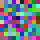

In [5]:
# Utils
def display_img(input: torch.Tensor, size: float = 1.):
    """ Assumes tensor values in the range [0, 1] """
    with torch.no_grad():
        batch_size, num_channels, height, width = input.shape
        img = torch.nn.functional.interpolate(input, (int(size*height), int(size*width)), mode='area')
        img_show = img.cpu()[0].transpose(0, 1).transpose(1, 2)
        img_out = (img_show * 255).clamp(0, 255).to(torch.uint8)
        display(PIL.Image.fromarray(img_out.cpu().numpy(), 'RGB'))
        pl.show()


def stylegan_to_rgb(input: torch.Tensor) -> torch.Tensor:
    return (input * 127.5 + 128) / 255


display_img(torch.rand(1, 3, 10, 10, requires_grad=False), 4)

Original image


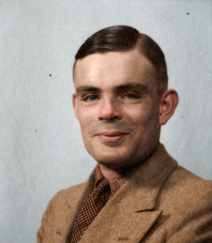


Cropped and aligned image.


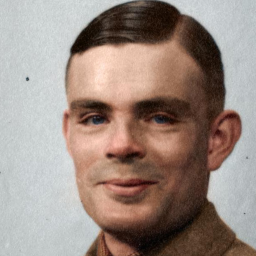

In [6]:
# Download and convert image to open cv format
img_url = 'https://i.redd.it/51dcpxhdwcox.jpg' #@param {type:"string"}
img_org = PIL.Image.open(utils.get_img(img_url)).convert('RGB')
img_open_cv_format = utils.img_pil_to_opencv(img_org)

# dlib facial landmark detection
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
rects = detector(image=img_open_cv_format)
shape = predictor(img_open_cv_format, rects[0])
landmarks = [(point.x, point.y) for point in shape.parts()]

# Crop and align image from landmarks
img = sg_ops.align_image(img_org, landmarks)
img.save('face_img.png') # Save aligned image.

# Display images
to_tensor = torchvision.transforms.ToTensor()
print("Original image")
display_img(to_tensor(img_org).unsqueeze(0), 0.25)
print("\nCropped and aligned image.")
display_img(to_tensor(img).unsqueeze(0).cuda(), 0.25)

In [7]:
#@title # Look for the face in latent space 
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})''')) # Make output window small.

outdir = 'out'
num_steps = 800
save_video = False
target = 'face_img.png'
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl'
command = f"""python stylegan2-ada-pytorch/projector.py \
              --outdir={outdir} --num-steps {num_steps} --save-video {save_video} --target={target} --network={network_pkl}"""
! $command

<IPython.core.display.Javascript object>

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/600: dist 0.65 loss 24567.20
step    2/600: dist 0.61 loss 27640.51
step    3/600: dist 0.59 loss 26860.03
step    4/600: dist 0.59 loss 25384.96
step    5/600: dist 0.58 loss 23366.65
step    6/600: dist 0.56 loss 20952.86
step    7/600: dist 0.58 loss 18269.37
step    8/600: dist 0.56 loss 15447.2

In [10]:
# Load CLIP models
perceptor, normalize_image = structure.clip.load('ViT-B/16', jit=False)

In [14]:
#@title # Prompt and training parameters{ run: "auto" }
#@markdown Write your image prompt in the txt field below.

#@markdown Prompt suggestions:
#@markdown * "portrait painting of android from dystopic future by James Gurney"
#@markdown * "portrait of anime character in the style of studio ghibli | cute anime character"

txt = "portrait of anime character in the style of studio ghibli | cute anime character" #@param {type:"string"}

# Training parameters
iterations = 400 #@param {type:"integer"}
grad_acc_steps = 1
batch_size = 1
lr_G_start = 4e-4 #@param {type:"number"}
lr_G_end = 1e-5 #@param {type:"number"}
lr_c = 5e-2 
loss_scale = 100.
steps_show = 8
truncation_psi = 0.6
clamp_val = 1e-30
drop_G = 0.5
drop_c = 0.0

# Sampler
sample_size = 224
kernel_min = 1
kernel_max = 256
grid_size_min = 224
grid_size_max = 8*224
noise = 1.
noise_std = 0.3
cutout = 0.
cutout_size = 0.25
perspective = 1.
downsamples = 2

network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl'

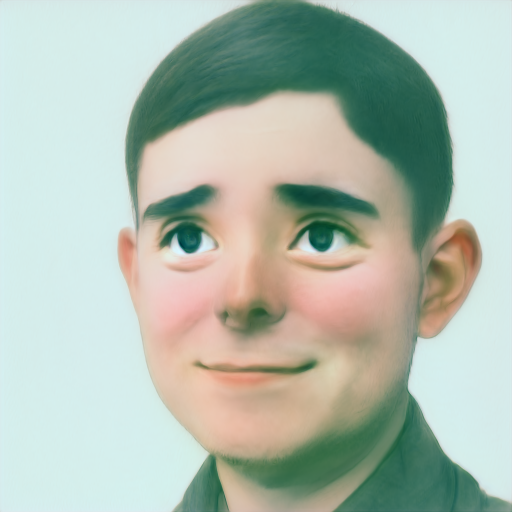

399 27.650060653686523 -0.04875040054321289 1.0171031951904297
399         <--


In [15]:
#@title Train loop {vertical-output: true}
#@markdown Loading and fine-tuning the model.
#@markdown The image shown during training is displayed at half size.

w_face = torch.tensor(np.load('out/projected_w.npz')['w']).cuda()

device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
G = G.train()
for p in G.parameters():
    p.requires_grad = True
cls = None

c = torch.eye(3, device=device)
c.requires_grad = True
c_bias = torch.zeros([3], device=device)
c_bias.requires_grad = True
c_scale = torch.ones([1], device=device)
c_scale.requires_grad = True

mix = torch.zeros([1], device=device)
mix.requires_grad = True

# Training cute demon #film #eternity | trending on artstation | art
txt_tok = structure.clip.tokenize(txt)
text_latent = perceptor.encode_text(txt_tok.to(device)).repeat(12, 1).detach()
sampler = torch.jit.script(
              structure.sample.ImgSampleBase(kernel_min=kernel_min,
                                             kernel_max=kernel_max,
                                             grid_size_min=grid_size_min,
                                             grid_size_max=grid_size_max,
                                             noise=noise,
                                             noise_std=noise_std,
                                             cutout=cutout,
                                             cutout_size=cutout_size,
                                             perspective=perspective,
                                             downsamples=downsamples).to(device)
          )

optimizer = structure.optim.ClampSGD([
            {'params': list(G.parameters()), 'lr': lr_G_start, 'clamp': clamp_val, 'drop': drop_G},
            {'params': [c, c_bias, c_scale, mix], 'lr': lr_c, 'clamp': clamp_val, 'drop': drop_c}
        ])

print('Generating image.')
#for i in range(iterations):
for i, lr in zip(range(iterations), torch.linspace(lr_G_start, lr_G_end, iterations)):
    optimizer.param_groups[0]['lr'] = lr.item()

    if (i + 1) % steps_show == 0:
        with torch.no_grad():
            clear_output(True)
            z = torch.randn([1, G.z_dim], device=device)          
            img = G.synthesis(w_face, noise_mode='const')
            img = structure.transform.color(img, c, c_bias, c_scale)*torch.sigmoid(mix) + stylegan_to_rgb(img)*(1.-torch.sigmoid(mix))
            display_img(img, 0.5)
            print(i, 
                  loss.item(),
                  img.min().item(), 
                  img.max().item(),) 
    
    for j in range(grad_acc_steps):
        optimizer.zero_grad()
        z = torch.randn([1, G.z_dim], device=device)
        img = G(z, cls, truncation_psi, noise_mode='random')
        img = structure.transform.color(img, c, c_bias, c_scale)*torch.sigmoid(mix) + stylegan_to_rgb(img)*(1.-torch.sigmoid(mix))
        img = sampler(img, size=sample_size, bs=batch_size)
        img = normalize_image(img)
        img_latents = perceptor.encode_image(img)
        _text_latent = torch.cat([text_latent, torch.randn(116, 512, device=device)])
        _img_latents = torch.cat([img_latents, torch.randn(116, 512, device=device)])
        pos = torch.zeros([128, 128], device=device)
        pos[:12, :12] = 1.
        loss = ops.infoLOOB_loss(_text_latent, _img_latents, pos > 0.5, 14.3)

        loss.backward()
        if (i + 1) % 2 == 0:
            print(i, ' '*(steps_show - ((i + 1) % steps_show)) + '<--')

    optimizer.step()

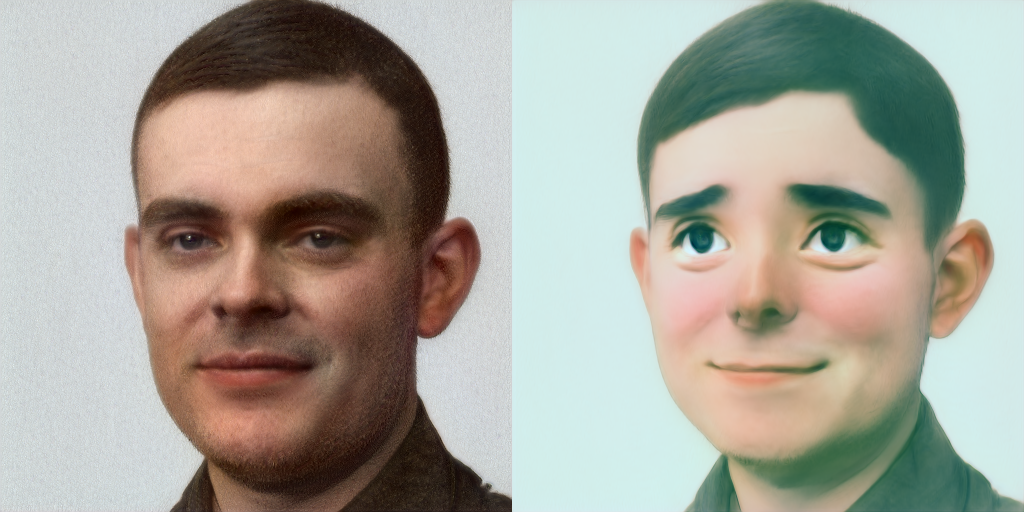

In [16]:
with torch.inference_mode(mode=True):
    G.eval()
    for p in G.parameters():
        p.requires_grad = False

    with dnnlib.util.open_url(network_pkl) as f:
        G_org = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
    for p in G_org.parameters():
        p.requires_grad = False

    z = torch.randn(1, 512, device=device)

    #img_g_org = G_org(z, cls, truncation_psi)
    img_g_org = G_org.synthesis(w_face, noise_mode='const')
    img_g_org = stylegan_to_rgb(img_g_org)

    #img_g = G(z, cls, truncation_psi)
    img_g = G.synthesis(w_face, noise_mode='const')
    img_g = structure.transform.color(img_g, c, c_bias, c_scale)*torch.sigmoid(mix) + stylegan_to_rgb(img_g)*(1.-torch.sigmoid(mix))
    
    img = torch.cat([img_g_org, img_g], dim=3)
    
    display_img(img, 0.5)

    del G_org

In [ ]:
#@title Generate full size images from the fine-tuned model
with torch.no_grad():
    clear_output(True)
    z = torch.randn([1, G.z_dim], device=device)
    img = G.synthesis(w_face, noise_mode='const')
    img = structure.transform.color(img, c, c_bias, c_scale)*torch.sigmoid(mix) + stylegan_to_rgb(img)*(1.-torch.sigmoid(mix))
    display_img(img, 1.)